# Frequency-switched Data Reduction
-----------------------------------

This notebook shows how to use `dysh` to calibrate a frequency switched observations. The idea is similar to an OnOff observation, except the telescope does not move to an Off in position, but move their IF in frequency space. Here we call the On/Off the Sig and Ref. Since the telescope observes in a Track mode, combining the sig and a shifted (folded) ref, a $\sqrt{2}$ improvement in S/N can be achieved.

It retrieves and calibrates frequency-switched scans using `GBTFITSLoad.getfs()`, which returns a `ScanBlock` object.  

In [1]:
import os
import wget
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad
import dysh.util as util
import numpy as np

## First, we download the example SDFITS data, if necessary.


In [2]:
filename = "AGBT20B_014_03.raw.vegas.A.fits"
if not os.path.isfile(filename):
    url = f"http://www.gb.nrao.edu/dysh/example_data/fs-L/data/AGBT20B_014_03.raw.vegas/{filename}"
    print(f"Downloading {filename}")
    wget.download(url,out=filename)
    print(f"\nRetrieved {filename}")
else:
    print(f"{filename} already downloaded")

AGBT20B_014_03.raw.vegas.A.fits already downloaded


In [3]:
sdfits = GBTFITSLoad(filename)
sdfits.info()
sdfits.summary()

Filename: AGBT20B_014_03.raw.vegas.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   352R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '16384E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,6,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,72.712573,28.957453


### Now retrieve and calibrate the frequency-switched scan
The default is to fold the sig and ref to create the final spectrum.  Use `fold=False` to not fold them.

In [4]:
fsscan = sdfits.getfs(scan=6, ifnum=0, plnum=1)

/home/mpound/src/dysh/src/dysh/spectra/core.py:354: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


In [5]:
ta = fsscan.timeaverage(weights='tsys')

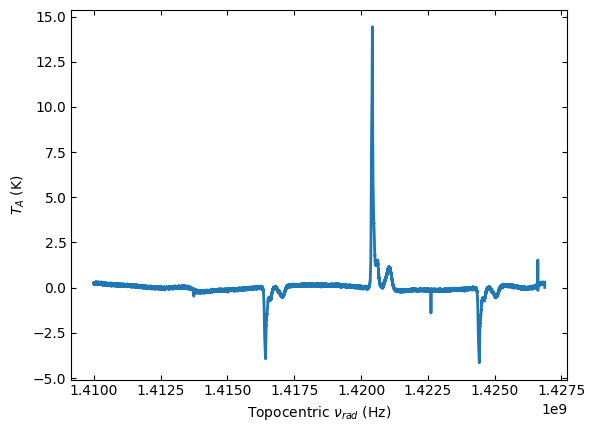

In [6]:
ta.plot()

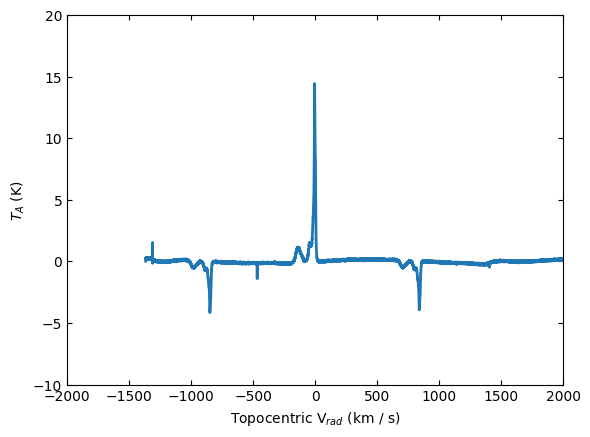

In [7]:
ta.plot(xaxis_unit="km/s",yaxis_unit="K",ymin=-10,ymax=20,xmin=-2000,xmax=2000)

### Plot x axis in channel units and remove a baseline with a compound exclusion region.
Right now, compound exclusions only work in channel space.

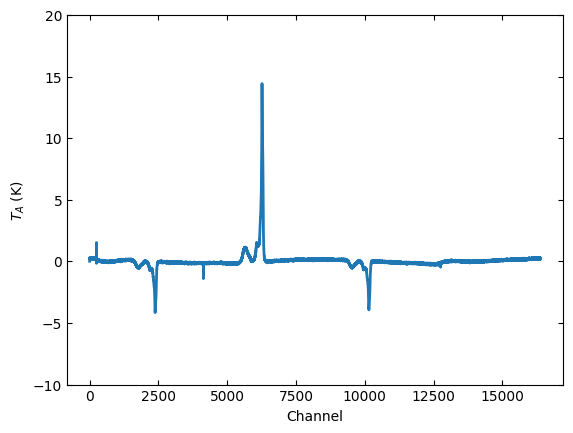

EXCLUDING [Spectral Region, 1 sub-regions:
  (1423784324.3398438 Hz, 1425844260.8632812 Hz) 
, Spectral Region, 1 sub-regions:
  (1419664451.2929688 Hz, 1421724387.8164062 Hz) 
, Spectral Region, 1 sub-regions:
  (1415544578.2460938 Hz, 1418119498.9003906 Hz) 
]


 [astropy.modeling.fitting]


In [8]:

ta.plot(xaxis_unit="chan",yaxis_unit="K",ymin=-10,ymax=20)
ta.baseline(degree=2,exclude=[(1000,3000),(5000,7000),(8500,11000)],remove=True)

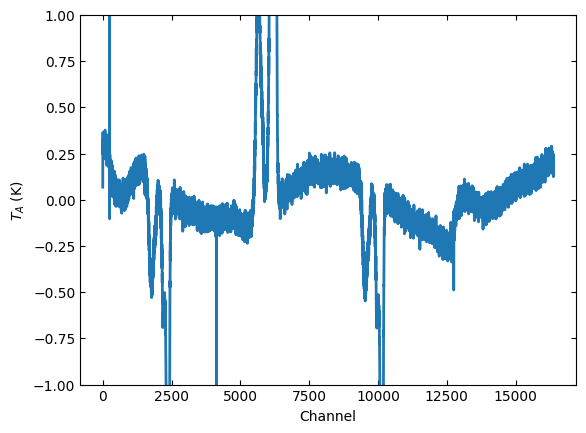

In [9]:
ta.plot(ymin=-1,ymax=1,xaxis_unit='channel')

In [10]:
print(ta.baseline_model)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                  c1                      c2          
            K                 K / Hz                 K / Hz2        
    ----------------- ---------------------- -----------------------
    7.735236225877392 -5.459874717655067e-09 -3.8395222534129496e-36


In [11]:
ta.savefig("baselined_removed.png")

---

### Now do the calibration using selection

In [12]:
sdfits.select(scan=6,ifnum=0)

In [13]:
fsscan2=sdfits.getfs(plnum=1)

/home/mpound/src/dysh/src/dysh/spectra/core.py:354: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


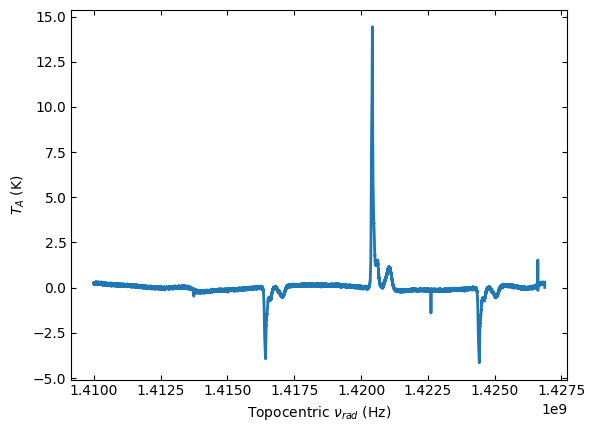

In [14]:
fsscan2.timeaverage().plot()

### Get the other polarization and plot

In [15]:
fsscan3=sdfits.getfs(plnum=0)

/home/mpound/src/dysh/src/dysh/spectra/core.py:354: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


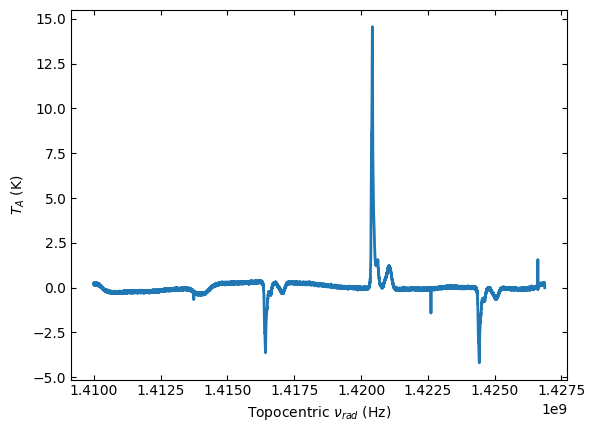

In [16]:
fsscan3.timeaverage().plot()

### Average the polarizations

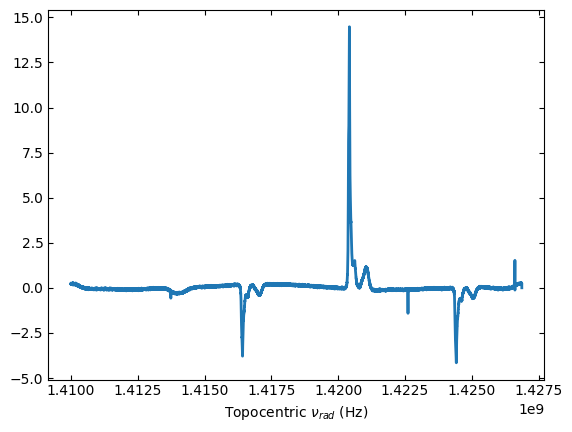

In [17]:
avg = fsscan2.timeaverage()+fsscan3.timeaverage()
avg *= 0.5
avg.plot()